In [8]:
import torch
import os
import csv
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch import nn, optim
import pandas as pd
import numpy as np
from PIL import Image
from time import time
import matplotlib.pyplot as plt

import glob

In [2]:
class TrainDatasetFromImages(Dataset):
    def __init__(self, csv_path):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = Image.open("data/training/"+single_image_name)

        t = transforms.Resize((60,171))
        
        img_as_img = t(img_as_img)
        
        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)
        
        cropped_img = img_as_tensor[:,15:45,15:99]
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        single_image_label = torch.tensor([single_image_label], dtype=torch.long)
        
        return (cropped_img, single_image_label)

    def __len__(self):
        return self.data_len

#if __name__ == "__main__":
    # Call dataset
#    custom_mnist_from_images =  \
#        CustomDatasetFromImages('data/training')
print("low")

low


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


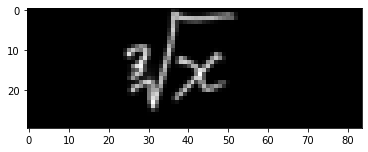

In [3]:
train_data = TrainDatasetFromImages('data/training/labels-tab-csv.csv')

#crop_data = []
#for i in range(860):
#    crop_data.append(train_data[i][0][:,15:45,15:99])
    

plt.imshow(train_data[2][0].numpy().squeeze(), cmap='gray_r');
print(train_data[2][0])

            
        


In [4]:
input_size = 2520
hidden_sizes = [250]
output_size = 11 #might be an issue

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.LogSoftmax(dim=1))

In [5]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_data))
images = images.reshape(images.shape[0], -1)
logps = model(images) 
print(images.shape, labels.shape)
loss = criterion(logps, labels)


optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.91)
time0 = time()
epochs = 50
for e in range(epochs):
    running_loss = 0
    for images, labels in train_data:
        images = images.reshape(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_data)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

torch.Size([1, 2520]) torch.Size([1])
Epoch 0 - Training loss: 2.5623958138532417
Epoch 1 - Training loss: 2.4177309223385746
Epoch 2 - Training loss: 2.351614664876184
Epoch 3 - Training loss: 2.291789073722307
Epoch 4 - Training loss: 2.237115376148113
Epoch 5 - Training loss: 2.186886610957079
Epoch 6 - Training loss: 2.140532170686611
Epoch 7 - Training loss: 2.097570723503135
Epoch 8 - Training loss: 2.0575914497638856
Epoch 9 - Training loss: 2.0202428166949473
Epoch 10 - Training loss: 1.9852219252045764
Epoch 11 - Training loss: 1.9522684214246828
Epoch 12 - Training loss: 1.9211574856625047
Epoch 13 - Training loss: 1.8916954505928727
Epoch 14 - Training loss: 1.8637153481674749
Epoch 15 - Training loss: 1.8370726301053235
Epoch 16 - Training loss: 1.8116425553380058
Epoch 17 - Training loss: 1.78731686838491
Epoch 18 - Training loss: 1.7640014859999336
Epoch 19 - Training loss: 1.7416143687398629
Epoch 20 - Training loss: 1.7200835538551558
Epoch 21 - Training loss: 1.6993462

In [6]:
valloader = TrainDatasetFromImages('data/training/labels-tab-csv.csv')

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].reshape(1, 2520)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    #print(pred_label)
    
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))



Number Of Images Tested = 860

Model Accuracy = 0.6930232558139535


In [24]:
filelist = glob.glob('data/Toy_test/*.png')

test_data = []

for x in filelist:
    img = Image.open(x)
    t = transforms.Resize((60,171))
    t1 = transforms.ToTensor()
        
    img = t(img)
        
    # Transform image to tensor
    img = t1(img)
        
    img = img[:,15:45,15:99]
    #img = torch.tensor([img], dtype=torch.long)
    test_data.append(img.squeeze())
    

predictions = []
for i in range(len(test_data)):
    img = test_data[i].reshape(1, 2520)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    predictions.append(pred_label)

with open('predictions', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    print(predictions)
    
    writer.writerows([i] for i in predictions)
#plt.imshow(test_data[30][0].numpy().squeeze(), cmap='gray_r');
#print(test_data[30])

[2, 4, 3, 10, 3, 8, 4, 4, 8, 8, 8, 6, 2, 6, 4, 4, 4, 3, 9, 4, 7, 6, 6, 4, 4, 4, 10, 9, 5, 8, 8, 4, 10, 5, 8, 1, 5, 8, 5, 6, 4, 7, 8, 8, 3, 4, 9, 8, 8, 7, 5, 7, 8, 8, 3, 8, 4, 5, 3, 9, 10, 4, 5, 8, 3, 3, 3, 5, 4, 8, 3, 10, 4, 8, 6, 3, 4, 8, 9, 9, 4, 8, 8, 7, 1, 7, 3, 4, 8, 3, 8, 3, 5, 3, 8, 5, 8, 4, 4, 3]
